In [1280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv('/Users/antreasantoniou/Downloads/gate-evolve-output.csv')

In [1281]:
def display_custom(df):
    # visualize using tabulate for ipython noteboooks
    from IPython.display import display

    # Assuming df is your DataFrame
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(
            df
        )

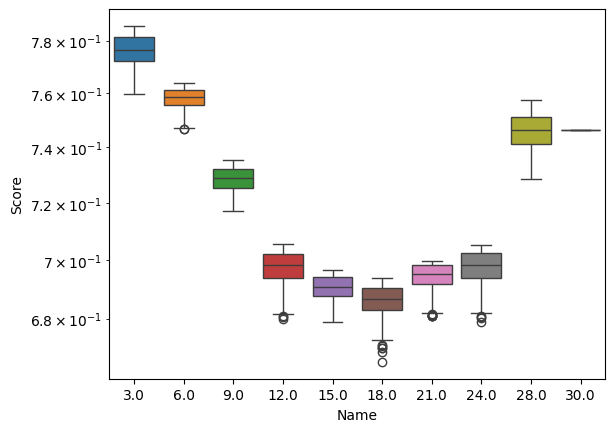

In [1282]:
# Initialize a DataFrame to store the simulated data
sim_data = pd.DataFrame()

# For each row in the data, simulate a dataset and add it to sim_data
for idx, row in data.iterrows():
    # Use the normal distribution to simulate data
    if int(row["Name"]) > 2:
        simulated = np.random.normal(loc=row['mean_score'], scale=row['std_score'], size=1000)
        # Clip the simulated data at the min and max values
        simulated = np.clip(simulated, row['min_score'], row['max_score'])
        # Add the simulated data to the DataFrame
        sim_data[str(row['Name'])] = pd.Series(simulated)

# Plot a boxplot of the simulated data
# plt.figure(figsize=(10,6))
sns.boxplot(data=sim_data)
plt.xlabel('Name')
plt.ylabel('Score')
plt.yscale('log')
plt.show()


In [1283]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data
# Initialize a DataFrame to store the simulated data
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data


# Create traces for data points 1 and 2
traces_1_2 = []
for idx, row in data.iterrows():
    if int(row['Name']) <= 2:
        traces_1_2.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create traces for data points 3 and above
traces_3_plus = []
for idx, row in data.iterrows():
    if int(row['Name']) > 2:
        traces_3_plus.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create a figure with two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("k=1, 2", "k>=3"))

# Add traces to the subplots
for trace in traces_1_2:
    fig.add_trace(trace, row=1, col=1)

for trace in traces_3_plus:
    fig.add_trace(trace, row=1, col=2)

# Update the layout
fig.update_layout(
    # title_text="Mean Squared Error for Different Number of Datasets (k)",
    
    yaxis_title='MSE',
    # xaxis_title='k (num datasets)',
    width=900,  # Width of the figure in pixels
    # height=400,  # Height of the figure in pixels
    autosize=False,
    showlegend=False,
    margin=dict(l=0, r=10, t=50, b=50),
    font=dict(
        family="Arial",  # Font family
        size=20,  # Font size
    ),
    # yaxis=dict(
    #     title_font=dict(
    #         size=14,  # Y-axis title font size
    #     ),
    #     tickfont=dict(
    #         size=12,  # Y-axis tick font size
    #     ),
    # ),
    # xaxis=dict(
    #     tickfont=dict(
    #         size=12,  # X-axis tick font size
    #     ),
    # ),
)
# Save the figure as a PDF
fig.write_image("boxplots.pdf")
fig.show()




In [1284]:
import pandas as pd
import plotly.express as px

# Load the data from the CSV file
data = pd.read_csv('k=12-1.csv')

# Calculate the difference from 'full' variant
full_score = data[data['Name'] == 'full']['Score'].values[0]
data['Score Difference'] = data['Score'] - full_score
font_size = 18
# Create a line chart with markers using Plotly
fig = px.bar(data, x='Name', y='Score Difference', labels={'Name': 'Dataset Name', 'Score Difference':'Score Difference (lower is better)'})
fig.update_layout(
    # height=300,
    width=500,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("figure.pdf")
# Show the figure
fig.show()

In [1285]:
sub_gate_columns = data["Name"]

sub_gate_columns = sub_gate_columns[1:]
sub_gate_columns = ["newyorkercaptioncontest" if col == "nycc" else col for col in sub_gate_columns]
print(sub_gate_columns)


[
    'chexpert',
    'pascal',
    'places365',
    'imagenet1k',
    'ade20k',
    'ham10k',
    'kinetics',
    'clevr',
    'ucf',
    'food101',
    'newyorkercaptioncontest',
    'flickr30k'
]

In [1286]:
import pathlib

import yaml

def load_data_as_df(filepath):
    df = pd.read_csv(filepath)
    task_dataset_dict = yaml.safe_load(open("task_mapping.yaml"))

    # Concatenating the header with the first row
    new_headers = [f"{col.split('.')[0]}.{df.iloc[0][idx]}" for idx, col in enumerate(df.columns)]

    # Setting the new concatenated values as column names
    df.columns = new_headers

    # Removing the first row from the DataFrame
    df = df.drop(df.index[0])

    # Resetting the DataFrame index
    df.reset_index(drop=True, inplace=True)
    
    columns = df.columns.tolist()[1:]
    model_names = df.columns.tolist()[0]
    # remove all datapoints with less than 50% on imagenet1k.1

    # Replace NA with 5
    df = df.fillna(1)
    # model_names = df[model_names][1:]

    # Convert all columns (except the first) to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # All columns that have mae in the name should be divided by 5 and then the result should be subtracted from 1 and multiplied by 100
    mae_columns = df.columns[df.columns.str.contains('dice', case=False)]
    for col in mae_columns:
        df[col] = (1-df[col]) * 100
    
    # columns with mae or loss in their name (except those with dice loss) should be divided by 4 and then the result should be subtracted from 1 and multiplied by 100
    
    selected_columns = df.columns[df.columns.str.contains('mae|loss', case=False) & ~df.columns.str.contains('dice', case=False)]
    for col in selected_columns:
        df[col] = (1-df[col] / 7.) * 100
        
    for col in df.columns[1:]:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    
    # for col in columns:
    #     df[col] = (df[col] - df[col].min())
    
    # gaussian normalization
    # for col in columns:
    #     df[col] = (df[col] - df[col].mean()) / df[col].std()
    
    # Add a new column for each task, where the value is the mean of the columns that are in the task
    for task, datasets in task_dataset_dict.items():
        df[task] = df[datasets].mean(axis=1)
    
    return df

source_csv_filepath = (
    "13032024-full.csv"
)
source_csv_filepath = pathlib.Path(source_csv_filepath)

df = load_data_as_df(source_csv_filepath)
display_custom(df)


/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_60051/553669900.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Model.Metric,cityscapes.mIoU,cityscapes.dice-loss,acdc.dice-loss,ade20k.mIoU,ade20k.dice-loss,aircraft.acc@1,chexpert.auc,cifar100.loss,cifar100.acc@5,cifar100.acc@1,clevr.acc@1,clevr-math.acc@5,clevr-math.acc@1,coco-10k.mIoU,coco-10k.dice-loss,coco-164k.mIoU,coco-164k.dice-loss,cubirds.acc@1,diabetic.auc,dtextures.acc@1,flickr30k.text-to-image-acc@5,flickr30k.text-to-image-acc@1,flickr30k.image-to-text-acc@1,flickr30k.image-to-text-acc@5,food101.loss,food101.acc@5,food101.acc@1,fungi.acc@1,ham10k.auc,hmdb51.acc@5,hmdb51.acc@1,imagenet1k.loss,imagenet1k.acc@5,imagenet1k.acc@1,iwildcam.mae,kinetics.acc@5,kinetics.acc@1,mini.acc@1,newyorkercaptioncontest.text-to-image-acc@5,newyorkercaptioncontest.text-to-image-acc@1,newyorkercaptioncontest.image-to-text-acc@1,newyorkercaptioncontest.image-to-text-acc@5,nyu.mIoU,nyu.dice-loss,omniglot.acc@1,pascal.mIoU,pascal.dice-loss,places365.loss,places365.acc@5,places365.acc@1,pokemonblipcaptions.text-to-image-acc@5,pokemonblipcaptions.text-to-image-acc@1,pokemonblipcaptions.image-to-text-acc@1,pokemonblipcaptions.image-to-text-acc@5,ucf.acc@5,ucf.acc@1,vgg.acc@1,winoground.text-to-image-acc@1,winoground.image-to-text-acc@1,Image Classification,Few Shot Image Classification,Image Segmentation,Image Relational Reasoning,Medical Classification/Segmentation,Image to Text Zero Shot Learning,Video Classification,Video Regression
0,AR-ViT-B16-224,57.848,35.19,42.9,17.353,22.3,94.4,81.3,76.628571,83.629,55.742,52.828,98.850,58.849,22.783,2.7,21.321,3.0,94.4,83.9,79.9,18.8,5.3,5.5,18.7,91.685714,96.630,83.834,77.5,98.5,57.917,28.385,86.185714,93.007,78.199,41.528571,63.288,36.718,98.7,19.5,5.2,5.4,18.7,8.345,72.9,98.6,15.460,21.9,70.542857,78.706,46.641,82.1,64.0,62.8,79.4,84.369,65.374,95.5,56.9,61.1,78.452571,91.285714,25.091667,70.175667,76.650,35.957143,56.008500,41.528571
1,BART,0.000,0.00,25.3,0.380,33.2,53.0,63.7,43.071429,29.170,8.967,42.563,96.450,41.761,0.056,4.1,0.110,3.5,50.3,55.1,35.4,7.9,1.6,1.5,7.8,44.442857,31.844,11.504,33.7,85.9,9.961,1.953,5.400000,3.107,0.713,35.871429,1.277,0.256,37.3,8.1,1.6,1.6,8.1,4.893,76.0,84.1,1.002,44.4,25.028571,11.058,2.953,74.8,55.6,55.6,69.4,5.444,1.031,59.4,47.7,48.8,18.104905,50.457143,13.970083,60.258000,57.500,27.864286,3.320333,35.871429
2,BERT,0.000,0.00,4.1,0.360,33.0,59.0,66.2,47.357143,38.137,14.520,42.593,97.400,44.265,0.055,3.8,0.096,3.4,47.4,57.6,37.6,8.1,1.6,1.5,8.3,50.014286,42.442,18.191,32.8,91.1,9.766,1.953,7.528571,4.616,1.173,34.628571,1.269,0.233,39.6,8.2,1.5,1.6,8.5,5.503,75.9,90.2,0.961,45.5,28.457143,16.037,4.795,75.6,59.9,58.7,72.2,6.040,1.287,59.4,50.4,50.3,22.772345,52.285714,14.047917,61.419333,54.750,29.028571,3.424667,34.628571
3,CLIP-B16-224,65.142,40.06,46.2,33.804,31.3,96.5,81.6,87.028571,93.760,74.731,52.622,99.113,61.218,29.609,3.2,30.369,4.6,97.9,86.7,84.3,20.9,5.5,6.2,20.6,95.628571,98.679,91.496,85.4,98.6,70.039,40.404,89.257143,95.708,81.815,48.385714,71.240,44.574,96.2,21.0,5.7,6.0,19.9,7.545,71.3,98.9,26.619,36.8,74.900000,83.864,53.445,85.2,67.9,61.8,81.7,88.238,71.440,98.9,54.0,48.6,85.026024,94.014286,31.695667,70.984333,78.275,36.071429,64.322500,48.385714
4,ConvNextV2-Base,62.341,41.78,36.4,37.253,52.8,96.7,81.8,90.857143,97.422,84.126,52.606,99.787,77.402,26.840,85.3,25.059,83.1,98.0,87.5,85.0,21.2,5.5,6.0,20.5,96.114286,98.991,92.896,85.7,99.1,77.539,50.326,90.928571,96.851,85.288,50.771429,75.765,49.011,95.8,21.4,5.8,6.3,21.0,5.260,77.5,98.6,32.665,70.3,76.300000,85.325,54.726,80.3,61.0,61.6,78.3,94.737,84.106,99.6,47.8,39.8,87.485417,94.200000,50.016500,76.598333,76.200,34.035714,71.914000,50.771429
5,DINO-B16-224,60.224,36.13,48.5,18.610,26.7,95.6,81.9,82.857143,89.590,66.282,52.846,99.188,61.001,24.968,3.1,24.292,4.9,95.9,84.7,79.1,19.6,4.6,5.4,18.6,93.171429,97.449,86.519,81.2,98.7,56.525,27.995,80.342857,88.493,67.529,42.714286,55.634,29.529,89.9,20.0,5.2,5.3,19.0,6.138,71.4,98.7,18.184,30.2,71.614286,79.704,47.454,85.6,68.2,65.5,81.8,77.125,52.769,95.9,48.3,49.5,79.250476,90.900000,27.070500,71.0

In [1287]:
def move_column(df, column_name, position):
    """
    Move a specific column to a specified position in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to modify.
    column_name (str): The name of the column to move.
    position (int): The position to move the column to.

    Returns:
    pandas.DataFrame: The modified DataFrame.
    """
    # Ensure the position is within the valid range
    if position < 0 or position > len(df.columns):
        raise ValueError(f"Position must be between 0 and {len(df.columns)}")

    # Get a list of the column names
    cols = df.columns.tolist()

    # Check if the column name is in the list
    if column_name in cols:
        # Remove the column from its current position
        cols.remove(column_name)

        # Insert the column at the specified position
        cols.insert(position, column_name)

        # Reorder the DataFrame
        df = df[cols]

    return df

In [1288]:
import yaml

task_to_dataset_metrics = yaml.safe_load(open("task_mapping.yaml"))
idx = 1
for task_name, dataset_metrics in task_to_dataset_metrics.items():
    for metric in dataset_metrics:
        df = move_column(df, metric, idx)
        idx += 1
print(task_to_dataset_metrics)

{
    'Image Classification': [
        'cifar100.loss',
        'cifar100.acc@1',
        'cifar100.acc@5',
        'food101.loss',
        'food101.acc@5',
        'food101.acc@1',
        'imagenet1k.loss',
        'imagenet1k.acc@5',
        'imagenet1k.acc@1',
        'places365.loss',
        'places365.acc@5',
        'places365.acc@1'
    ],
    'Few Shot Image Classification': [
        'fungi.acc@1',
        'mini.acc@1',
        'omniglot.acc@1',
        'vgg.acc@1',
        'aircraft.acc@1',
        'dtextures.acc@1',
        'cubirds.acc@1'
    ],
    'Image Segmentation': [
        'ade20k.dice-loss',
        'ade20k.mIoU',
        'coco-10k.mIoU',
        'coco-10k.dice-loss',
        'coco-164k.mIoU',
        'coco-164k.dice-loss',
        'cityscapes.mIoU',
        'cityscapes.dice-loss',
        'nyu.mIoU',
        'nyu.dice-loss',
        'pascal.mIoU',
        'pascal.dice-loss'
    ],
    'Image Relational Reasoning': ['clevr.acc@1', 'clevr-math.acc@5', 'clevr-math.acc@1'],
    'Medical Classification/Segmentation': ['ham10k.auc', 'chexpert.auc', 'diabetic.auc', 'acdc.dice-loss'],
    'Image to Text Zero Shot Learning': [
        'flickr30k.text-to-image-acc@5',
        'flickr30k.text-to-image-acc@1',
        'flickr30k.image-to-text-acc@1',
        'flickr30k.image-to-text-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@5',
        'pokemonblipcaptions.text-to-image-acc@5',
        'pokemonblipcaptions.text-to-image-acc@1',
        'pokemonblipcaptions.image-to-text-acc@1',
        'pokemonblipcaptions.image-to-text-acc@5',
        'winoground.image-to-text-acc@1',
        'winoground.text-to-image-acc@1'
    ],
    'Video Classification': [
        'kinetics.acc@5',
        'kinetics.acc@1',
        'hmdb51.acc@5',
        'hmdb51.acc@1',
        'ucf.acc@5',
        'ucf.acc@1'
    ],
    'Video Regression': ['iwildcam.mae']
}

In [1289]:
model_names = df['Model.Metric']
print(model_names)
modality_shift = ["BART", "BERT", "Whisper", "MPNET"]
pretraining_shift = ["AR-ViT-B16-224", "CLIP-B16-224", "DINO-B16-224", "DeiT3-B16-224", "Flex-B-1200EP", "Laion-B16-224", "SIGLIP-P16-224"]
architecture_shift = ["AR-ViT-B16-224", "ConvNextV2-Base", "EffV2-RW-S", "RNX50-32x4A1", "SViT-B16-224", "EffFormer-s0"]

0      AR-ViT-B16-224
1                BART
2                BERT
3        CLIP-B16-224
4     ConvNextV2-Base
5        DINO-B16-224
6       DeiT3-B16-224
7        EffFormer-s0
8          EffV2-RW-S
9       Flex-B-1200EP
10      Laion-B16-224
11              MPNET
12       RNX50-32x4A1
13     SIGLIP-P16-224
14       SViT-B16-224
15            Whisper
Name: Model.Metric, dtype: object

In [1290]:
import numpy as np

def generate_palette(palette, target_length):
    if len(palette) >= target_length:
        return palette[:target_length]
    else:
        # Interpolate colors in the palette
        colors = np.array([px.colors.hex_to_rgb(color) for color in palette])
        new_colors = np.array([
            np.interp(np.linspace(0, len(colors) - 1, target_length), np.arange(len(colors)), colors[:, i])
            for i in range(3)
        ]).T.astype(int)
        return [f'rgb({r},{g},{b})' for r, g, b in new_colors]

In [1291]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(architecture_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['Model.Metric'].isin(architecture_shift)]
columns = new_df.columns
# gaussian normalization
for col in columns[1:]:
    new_df[col] = (new_df[col] - new_df[col].mean()) / (new_df[col].std())
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(architecture_shift):
    id = new_df[new_df['Model.Metric'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("architecture_polar_plot.pdf")
fig.write_image("architecture_polar_plot.png")

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_60051/3420618578.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1292]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(pretraining_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['Model.Metric'].isin(pretraining_shift)]
columns = new_df.columns
# gaussian normalization
for col in columns[1:]:
    new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(pretraining_shift):
    id = new_df[new_df['Model.Metric'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("pretraining_polar_plot.pdf")
fig.write_image("pretraining_polar_plot.png")

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_60051/4145886805.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1293]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(modality_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['Model.Metric'].isin(modality_shift)]
columns = new_df.columns
# gaussian normalization
for col in columns[1:]:
    new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(modality_shift):
    id = new_df[new_df['Model.Metric'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("modality_polar_plot.pdf")
fig.write_image("modality_polar_plot.png")

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_60051/3413461409.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1294]:
column_names = list(df.columns)

print(column_names)

[
    'Model.Metric',
    'cifar100.loss',
    'cifar100.acc@1',
    'cifar100.acc@5',
    'food101.loss',
    'food101.acc@5',
    'food101.acc@1',
    'imagenet1k.loss',
    'imagenet1k.acc@5',
    'imagenet1k.acc@1',
    'places365.loss',
    'places365.acc@5',
    'places365.acc@1',
    'fungi.acc@1',
    'mini.acc@1',
    'omniglot.acc@1',
    'vgg.acc@1',
    'aircraft.acc@1',
    'dtextures.acc@1',
    'cubirds.acc@1',
    'ade20k.dice-loss',
    'ade20k.mIoU',
    'coco-10k.mIoU',
    'coco-10k.dice-loss',
    'coco-164k.mIoU',
    'coco-164k.dice-loss',
    'cityscapes.mIoU',
    'cityscapes.dice-loss',
    'nyu.mIoU',
    'nyu.dice-loss',
    'pascal.mIoU',
    'pascal.dice-loss',
    'clevr.acc@1',
    'clevr-math.acc@5',
    'clevr-math.acc@1',
    'ham10k.auc',
    'chexpert.auc',
    'diabetic.auc',
    'acdc.dice-loss',
    'flickr30k.text-to-image-acc@5',
    'flickr30k.text-to-image-acc@1',
    'flickr30k.image-to-text-acc@1',
    'flickr30k.image-to-text-acc@5',
    'newyorkercaptioncontest.text-to-image-acc@5',
    'newyorkercaptioncontest.text-to-image-acc@1',
    'newyorkercaptioncontest.image-to-text-acc@1',
    'newyorkercaptioncontest.image-to-text-acc@5',
    'pokemonblipcaptions.text-to-image-acc@5',
    'pokemonblipcaptions.text-to-image-acc@1',
    'pokemonblipcaptions.image-to-text-acc@1',
    'pokemonblipcaptions.image-to-text-acc@5',
    'winoground.image-to-text-acc@1',
    'winoground.text-to-image-acc@1',
    'kinetics.acc@5',
    'kinetics.acc@1',
    'hmdb51.acc@5',
    'hmdb51.acc@1',
    'ucf.acc@5',
    'ucf.acc@1',
    'iwildcam.mae',
    'Image Classification',
    'Few Shot Image Classification',
    'Image Segmentation',
    'Image Relational Reasoning',
    'Medical Classification/Segmentation',
    'Image to Text Zero Shot Learning',
    'Video Classification',
    'Video Regression'
]

In [1295]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping.yaml"))
task_to_dataset = {k: [d for d in v if d in df.columns] for k, v in task_to_dataset.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_dataset.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_dataset)
print(task_to_dataset)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss',
        'cifar100.acc@1',
        'cifar100.acc@5',
        'food101.loss',
        'food101.acc@5',
        'food101.acc@1',
        'imagenet1k.loss',
        'imagenet1k.acc@5',
        'imagenet1k.acc@1',
        'places365.loss',
        'places365.acc@5',
        'places365.acc@1'
    ],
    'Few Shot Image Classification': [
        'fungi.acc@1',
        'mini.acc@1',
        'omniglot.acc@1',
        'vgg.acc@1',
        'aircraft.acc@1',
        'dtextures.acc@1',
        'cubirds.acc@1'
    ],
    'Image Segmentation': [
        'ade20k.dice-loss',
        'ade20k.mIoU',
        'coco-10k.mIoU',
        'coco-10k.dice-loss',
        'coco-164k.mIoU',
        'coco-164k.dice-loss',
        'cityscapes.mIoU',
        'cityscapes.dice-loss',
        'nyu.mIoU',
        'nyu.dice-loss',
        'pascal.mIoU',
        'pascal.dice-loss'
    ],
    'Image Relational Reasoning': ['clevr.acc@1', 'clevr-math.acc@5', 'clevr-math.acc@1'],
    'Medical Classification/Segmentation': ['ham10k.auc', 'chexpert.auc', 'diabetic.auc', 'acdc.dice-loss'],
    'Image to Text Zero Shot Learning': [
        'flickr30k.text-to-image-acc@5',
        'flickr30k.text-to-image-acc@1',
        'flickr30k.image-to-text-acc@1',
        'flickr30k.image-to-text-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@5',
        'pokemonblipcaptions.text-to-image-acc@5',
        'pokemonblipcaptions.text-to-image-acc@1',
        'pokemonblipcaptions.image-to-text-acc@1',
        'pokemonblipcaptions.image-to-text-acc@5',
        'winoground.image-to-text-acc@1',
        'winoground.text-to-image-acc@1'
    ],
    'Video Classification': [
        'kinetics.acc@5',
        'kinetics.acc@1',
        'hmdb51.acc@5',
        'hmdb51.acc@1',
        'ucf.acc@5',
        'ucf.acc@1'
    ],
    'Video Regression': ['iwildcam.mae']
}

{
    'cifar100.loss': 0.010416666666666666,
    'cifar100.acc@1': 0.010416666666666666,
    'cifar100.acc@5': 0.010416666666666666,
    'food101.loss': 0.010416666666666666,
    'food101.acc@5': 0.010416666666666666,
    'food101.acc@1': 0.010416666666666666,
    'imagenet1k.loss': 0.010416666666666666,
    'imagenet1k.acc@5': 0.010416666666666666,
    'imagenet1k.acc@1': 0.010416666666666666,
    'places365.loss': 0.010416666666666666,
    'places365.acc@5': 0.010416666666666666,
    'places365.acc@1': 0.010416666666666666,
    'fungi.acc@1': 0.017857142857142856,
    'mini.acc@1': 0.017857142857142856,
    'omniglot.acc@1': 0.017857142857142856,
    'vgg.acc@1': 0.017857142857142856,
    'aircraft.acc@1': 0.017857142857142856,
    'dtextures.acc@1': 0.017857142857142856,
    'cubirds.acc@1': 0.017857142857142856,
    'ade20k.dice-loss': 0.010416666666666666,
    'ade20k.mIoU': 0.010416666666666666,
    'coco-10k.mIoU': 0.010416666666666666,
    'coco-10k.dice-loss': 0.010416666666666666,
    'coco-164k.mIoU': 0.010416666666666666,
    'coco-164k.dice-loss': 0.010416666666666666,
    'cityscapes.mIoU': 0.010416666666666666,
    'cityscapes.dice-loss': 0.010416666666666666,
    'nyu.mIoU': 0.010416666666666666,
    'nyu.dice-loss': 0.010416666666666666,
    'pascal.mIoU': 0.010416666666666666,
    'pascal.dice-loss': 0.010416666666666666,
    'clevr.acc@1': 0.041666666666666664,
    'clevr-math.acc@5': 0.041666666666666664,
    'clevr-math.acc@1': 0.041666666666666664,
    'ham10k.auc': 0.03125,
    'chexpert.auc': 0.03125,
    'diabetic.auc': 0.03125,
    'acdc.dice-loss': 0.03125,
    'flickr30k.text-to-image-acc@5': 0.008928571428571428,
    'flickr30k.text-to-image-acc@1': 0.008928571428571428,
    'flickr30k.image-to-text-acc@1': 0.008928571428571428,
    'flickr30k.image-to-text-acc@5': 0.008928571428571428,
    'newyorkercaptioncontest.text-to-image-acc@5': 0.008928571428571428,
    'newyorkercaptioncontest.text-to-image-acc@1': 0.008928571428571428,
    'newyorkercaptioncontest.image-to-text-acc@1': 0.008928571428571428,
    'newyorkercaptioncontest.image-to-text-acc@5': 0.008928571428571428,
    'pokemonblipcaptions.text-to-image-acc@5': 0.008928571428571428,
    'pokemonblipcaptions.text-to-image-acc@1': 0.008928571428571428,
    'pokemonblipcaptions.image-to-text-acc@1': 0.008928571428571428,
    'pokemonblipcaptions.image-to-text-acc@5': 0.008928571428571428,
    'winoground.image-to-text-acc@1': 0.008928571428571428,
    'winoground.text-to-image-acc@1': 0.008928571428571428,
    'kinetics.acc@5': 0.020833333333333332,
    'kinetics.acc@1': 0.020833333333333332,
    'hmdb51.acc@5': 0.020833333333333332,
    'hmdb51.acc@1': 0.020833333333333332,
    'ucf.acc@5': 0.020833333333333332,
    'ucf.acc@1': 0.020833333333333332,
    'iwildcam.mae': 0.125
}

Sum of weights: 1.0

In [1296]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping.yaml"))
task_to_dataset = {k: [d for d in v if d in df.columns] for k, v in task_to_dataset.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_dataset.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_dataset)
print(task_to_dataset)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss',
        'cifar100.acc@1',
        'cifar100.acc@5',
        'food101.loss',
        'food101.acc@5',
        'food101.acc@1',
        'imagenet1k.loss',
        'imagenet1k.acc@5',
        'imagenet1k.acc@1',
        'places365.loss',
        'places365.acc@5',
        'places365.acc@1'
    ],
    'Few Shot Image Classification': [
        'fungi.acc@1',
        'mini.acc@1',
        'omniglot.acc@1',
        'vgg.acc@1',
        'aircraft.acc@1',
        'dtextures.acc@1',
        'cubirds.acc@1'
    ],
    'Image Segmentation': [
        'ade20k.dice-loss',
        'ade20k.mIoU',
        'coco-10k.mIoU',
        'coco-10k.dice-loss',
        'coco-164k.mIoU',
        'coco-164k.dice-loss',
        'cityscapes.mIoU',
        'cityscapes.dice-loss',
        'nyu.mIoU',
        'nyu.dice-loss',
        'pascal.mIoU',
        'pascal.dice-loss'
    ],
    'Image Relational Reasoning': ['clevr.acc@1', 'clevr-math.acc@5', 'clevr-math.acc@1'],
    'Medical Classification/Segmentation': ['ham10k.auc', 'chexpert.auc', 'diabetic.auc', 'acdc.dice-loss'],
    'Image to Text Zero Shot Learning': [
        'flickr30k.text-to-image-acc@5',
        'flickr30k.text-to-image-acc@1',
        'flickr30k.image-to-text-acc@1',
        'flickr30k.image-to-text-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@5',
        'newyorkercaptioncontest.text-to-image-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@1',
        'newyorkercaptioncontest.image-to-text-acc@5',
        'pokemonblipcaptions.text-to-image-acc@5',
        'pokemonblipcaptions.text-to-image-acc@1',
        'pokemonblipcaptions.image-to-text-acc@1',
        'pokemonblipcaptions.image-to-text-acc@5',
        'winoground.image-to-text-acc@1',
        'winoground.text-to-image-acc@1'
    ],
    'Video Classification': [
        'kinetics.acc@5',
        'kinetics.acc@1',
        'hmdb51.acc@5',
        'hmdb51.acc@1',
        'ucf.acc@5',
        'ucf.acc@1'
    ],
    'Video Regression': ['iwildcam.mae']
}

{
    'cifar100.loss': 0.010416666666666666,
    'cifar100.acc@1': 0.010416666666666666,
    'cifar100.acc@5': 0.010416666666666666,
    'food101.loss': 0.010416666666666666,
    'food101.acc@5': 0.010416666666666666,
    'food101.acc@1': 0.010416666666666666,
    'imagenet1k.loss': 0.010416666666666666,
    'imagenet1k.acc@5': 0.010416666666666666,
    'imagenet1k.acc@1': 0.010416666666666666,
    'places365.loss': 0.010416666666666666,
    'places365.acc@5': 0.010416666666666666,
    'places365.acc@1': 0.010416666666666666,
    'fungi.acc@1': 0.017857142857142856,
    'mini.acc@1': 0.017857142857142856,
    'omniglot.acc@1': 0.017857142857142856,
    'vgg.acc@1': 0.017857142857142856,
    'aircraft.acc@1': 0.017857142857142856,
    'dtextures.acc@1': 0.017857142857142856,
    'cubirds.acc@1': 0.017857142857142856,
    'ade20k.dice-loss': 0.010416666666666666,
    'ade20k.mIoU': 0.010416666666666666,
    'coco-10k.mIoU': 0.010416666666666666,
    'coco-10k.dice-loss': 0.010416666666666666,
    'coco-164k.mIoU': 0.010416666666666666,
    'coco-164k.dice-loss': 0.010416666666666666,
    'cityscapes.mIoU': 0.010416666666666666,
    'cityscapes.dice-loss': 0.010416666666666666,
    'nyu.mIoU': 0.010416666666666666,
    'nyu.dice-loss': 0.010416666666666666,
    'pascal.mIoU': 0.010416666666666666,
    'pascal.dice-loss': 0.010416666666666666,
    'clevr.acc@1': 0.041666666666666664,
    'clevr-math.acc@5': 0.041666666666666664,
    'clevr-math.acc@1': 0.041666666666666664,
    'ham10k.auc': 0.03125,
    'chexpert.auc': 0.03125,
    'diabetic.auc': 0.03125,
    'acdc.dice-loss': 0.03125,
    'flickr30k.text-to-image-acc@5': 0.008928571428571428,
    'flickr30k.text-to-image-acc@1': 0.008928571428571428,
    'flickr30k.image-to-text-acc@1': 0.008928571428571428,
    'flickr30k.image-to-text-acc@5': 0.008928571428571428,
    'newyorkercaptioncontest.text-to-image-acc@5': 0.008928571428571428,
    'newyorkercaptioncontest.text-to-image-acc@1': 0.008928571428571428,
    'newyorkercaptioncontest.image-to-text-acc@1': 0.008928571428571428,
    'newyorkercaptioncontest.image-to-text-acc@5': 0.008928571428571428,
    'pokemonblipcaptions.text-to-image-acc@5': 0.008928571428571428,
    'pokemonblipcaptions.text-to-image-acc@1': 0.008928571428571428,
    'pokemonblipcaptions.image-to-text-acc@1': 0.008928571428571428,
    'pokemonblipcaptions.image-to-text-acc@5': 0.008928571428571428,
    'winoground.image-to-text-acc@1': 0.008928571428571428,
    'winoground.text-to-image-acc@1': 0.008928571428571428,
    'kinetics.acc@5': 0.020833333333333332,
    'kinetics.acc@1': 0.020833333333333332,
    'hmdb51.acc@5': 0.020833333333333332,
    'hmdb51.acc@1': 0.020833333333333332,
    'ucf.acc@5': 0.020833333333333332,
    'ucf.acc@1': 0.020833333333333332,
    'iwildcam.mae': 0.125
}

Sum of weights: 1.0

In [1297]:
from re import sub
import yaml


sub_gate_metrics = [col for col in df.columns if any(term in col for term in sub_gate_columns)]

task_to_dataset = yaml.safe_load(open("task_mapping.yaml"))
reverse_task_to_dataset = {d: k for k, v in task_to_dataset.items() for d in v}
sub_gate_dataset_to_weight = {}

for dataset in sub_gate_metrics:
    if "rank" not in dataset:
        sub_gate_dataset_to_weight[dataset] = 1. / len(task_to_dataset[reverse_task_to_dataset[dataset]])

# normalize the weights
sub_gate_dataset_to_weight = {k: v / sum(sub_gate_dataset_to_weight.values()) for k, v in sub_gate_dataset_to_weight.items()}

print(sub_gate_dataset_to_weight)
print(f"sum of weights: {sum(sub_gate_dataset_to_weight.values())}")

{
    'food101.loss': 0.021806853582554513,
    'food101.acc@5': 0.021806853582554513,
    'food101.acc@1': 0.021806853582554513,
    'imagenet1k.loss': 0.021806853582554513,
    'imagenet1k.acc@5': 0.021806853582554513,
    'imagenet1k.acc@1': 0.021806853582554513,
    'places365.loss': 0.021806853582554513,
    'places365.acc@5': 0.021806853582554513,
    'places365.acc@1': 0.021806853582554513,
    'ade20k.dice-loss': 0.021806853582554513,
    'ade20k.mIoU': 0.021806853582554513,
    'pascal.mIoU': 0.021806853582554513,
    'pascal.dice-loss': 0.021806853582554513,
    'clevr.acc@1': 0.08722741433021805,
    'clevr-math.acc@5': 0.08722741433021805,
    'clevr-math.acc@1': 0.08722741433021805,
    'ham10k.auc': 0.06542056074766354,
    'chexpert.auc': 0.06542056074766354,
    'flickr30k.text-to-image-acc@5': 0.018691588785046724,
    'flickr30k.text-to-image-acc@1': 0.018691588785046724,
    'flickr30k.image-to-text-acc@1': 0.018691588785046724,
    'flickr30k.image-to-text-acc@5': 0.018691588785046724,
    'newyorkercaptioncontest.text-to-image-acc@5': 0.018691588785046724,
    'newyorkercaptioncontest.text-to-image-acc@1': 0.018691588785046724,
    'newyorkercaptioncontest.image-to-text-acc@1': 0.018691588785046724,
    'newyorkercaptioncontest.image-to-text-acc@5': 0.018691588785046724,
    'kinetics.acc@5': 0.043613707165109025,
    'kinetics.acc@1': 0.043613707165109025,
    'ucf.acc@5': 0.043613707165109025,
    'ucf.acc@1': 0.043613707165109025
}

sum of weights: 1.0

In [1298]:
from typing import Dict, List, Optional
import pandas as pd

def calculate_means(df, terms: Optional[List], prefix: Optional[str] = None, term_weight: Optional[Dict[str, float]] = None):
    # Find the metrics that contain any of the terms
    if not terms:
        included_metrics = df.columns[1:]
    else:
        included_metrics = [col for col in df.columns if any(term in col for term in terms)]

    # Separate the metrics into "lower is better" and "higher is better"
    lower_is_better_metrics = [col for col in included_metrics if 'loss' in col or 'mae' in col]
    higher_is_better_metrics = list(set(included_metrics) - set(lower_is_better_metrics))
    # print(lower_is_better_metrics)
    # print(higher_is_better_metrics)
    
    # Convert fractional values to percentages in the higher_is_better_metrics, if necessary
    for col in higher_is_better_metrics:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    
    if prefix is None:
        prefix = 'Mean'
    
    # Calculate the weighted sum for lower and higher is better metrics
    if term_weight is not None:
        df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in lower_is_better_metrics), axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in higher_is_better_metrics), axis=1)
    else:
        df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].mean(axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].mean(axis=1)
    
    # df[f'{prefix} (Lower is better)'] = df[lower_is_better_metrics].mean(axis=1)
    # df[f'{prefix} (Higher is better)'] = df[higher_is_better_metrics].mean(axis=1)

    return df


In [1299]:
df = calculate_means(df, None, 'GATE', term_weight=dataset_to_weight)
df = calculate_means(df, sub_gate_columns, 'devGATE', term_weight=sub_gate_dataset_to_weight)

In [1300]:
def add_average_rank_column(df):
    # Add a column for the average rank
    lower_is_better_columns = [col for col in df.columns if 'loss' in col or 'mae' in col]
    higher_is_better_columns = list(set(df.columns) - set(lower_is_better_columns))
    lower_is_better_ranks = df[lower_is_better_columns].rank(ascending=True)
    higher_is_better_ranks = df[higher_is_better_columns].rank(ascending=False)
    merged_ranks = pd.concat([lower_is_better_ranks, higher_is_better_ranks], axis=1)
    # df['Average Rank'] = merged_ranks.mean(axis=1).rank(ascending=True)
    return df
    
df["imagenet1k.acc@1 rank"] = df["imagenet1k.acc@1"].rank(ascending=False)
df["imagenet1k.acc@5 rank"] = df["imagenet1k.acc@5"].rank(ascending=False)
df["devGATE (Weighted Higher is better rank)"] = df["devGATE (Weighted Higher is better)"].rank(ascending=False)
df["GATE (Weighted Higher is better rank)"] = df["GATE (Weighted Higher is better)"].rank(ascending=False)
df["devGATE (Weighted Lower is better rank)"] = df["devGATE (Weighted Lower is better)"].rank(ascending=True)
df["GATE (Weighted Lower is better rank)"] = df["GATE (Weighted Lower is better)"].rank(ascending=True)
# df["devGATE (Higher is better) rank"] = df["devGATE (Higher is better)"].rank(ascending=False)
# df["GATE (Higher is better) rank"] = df["GATE (Higher is better)"].rank(ascending=False)

# df["imagenet1k.loss rank"] = df["imagenet1k.loss"].rank(ascending=True)
# df["devGATE (Lower is better) rank"] = df["devGATE (Lower is better)"].rank(ascending=True)
# df["GATE (Lower is better) rank"] = df["GATE (Lower is better)"].rank(ascending=True)

df = add_average_rank_column(df)
display_custom(df)

,Model.Metric,cifar100.loss,cifar100.acc@1,cifar100.acc@5,food101.loss,food101.acc@5,food101.acc@1,imagenet1k.loss,imagenet1k.acc@5,imagenet1k.acc@1,places365.loss,places365.acc@5,places365.acc@1,fungi.acc@1,mini.acc@1,omniglot.acc@1,vgg.acc@1,aircraft.acc@1,dtextures.acc@1,cubirds.acc@1,ade20k.dice-loss,ade20k.mIoU,coco-10k.mIoU,coco-10k.dice-loss,coco-164k.mIoU,coco-164k.dice-loss,cityscapes.mIoU,cityscapes.dice-loss,nyu.mIoU,nyu.dice-loss,pascal.mIoU,pascal.dice-loss,clevr.acc@1,clevr-math.acc@5,clevr-math.acc@1,ham10k.auc,chexpert.auc,diabetic.auc,acdc.dice-loss,flickr30k.text-to-image-acc@5,flickr30k.text-to-image-acc@1,flickr30k.image-to-text-acc@1,flickr30k.image-to-text-acc@5,newyorkercaptioncontest.text-to-image-acc@5,newyorkercaptioncontest.text-to-image-acc@1,newyorkercaptioncontest.image-to-text-acc@1,newyorkercaptioncontest.image-to-text-acc@5,pokemonblipcaptions.text-to-image-acc@5,pokemonblipcaptions.text-to-image-acc@1,pokemonblipcaptions.image-to-text-acc@1,pokemonblipcaptions.image-to-text-acc@5,winoground.image-to-text-acc@1,winoground.text-to-image-acc@1,kinetics.acc@5,kinetics.acc@1,hmdb51.acc@5,hmdb51.acc@1,ucf.acc@5,ucf.acc@1,iwildcam.mae,Image Classification,Few Shot Image Classification,Image Segmentation,Image Relational Reasoning,Medical Classification/Segmentation,Image to Text Zero Shot Learning,Video Classification,Video Regression,GATE (Weighted Lower is better),GATE (Weighted Higher is better),devGATE (Weighted Lower is better),devGATE (Weighted Higher is better),imagenet1k.acc@1 rank,imagenet1k.acc@5 rank,devGATE (Weighted Higher is better rank),GATE (Weighted Higher is better rank),devGATE (Weighted Lower is better rank),GATE (Weighted Lower is better rank)
0,AR-ViT-B16-224,76.628571,55.742,83.629,91.685714,96.630,83.834,86.185714,93.007,78.199,70.542857,78.706,46.641,77.5,98.7,98.6,95.5,94.4,79.9,94.4,22.3,17.353,22.783,2.7,21.321,3.0,57.848,35.19,8.345,72.9,15.460,21.9,52.828,98.850,58.849,98.5,81.3,83.9,42.9,18.8,5.3,5.5,18.7,19.5,5.2,5.4,18.7,82.1,64.0,62.8,79.4,61.1,56.9,63.288,36.718,57.917,28.385,84.369,65.374,41.528571,78.452571,91.285714,25.091667,70.175667,76.650,35.957143,56.008500,41.528571,11.563289,522.980274,6.380997,53.951564,5.0,8.0,7.0,7.0,7.0,6.0
1,BART,43.071429,8.967,29.170,44.442857,31.844,11.504,5.400000,3.107,0.713,25.028571,11.058,2.953,33.7,37.3,84.1,59.4,53.0,35.4,50.3,33.2,0.380,0.056,4.1,0.110,3.5,0.000,0.00,4.893,76.0,1.002,44.4,42.563,96.450,41.761,85.9,63.7,55.1,25.3,7.9,1.6,1.5,7.8,8.1,1.6,1.6,8.1,74.8,55.6,55.6,69.4,48.8,47.7,1.277,0.256,9.961,1.953,5.444,1.031,35.871429,18.104905,50.457143,13.970083,60.258000,57.500,27.864286,3.320333,35.871429,8.182292,292.582159,3.324922,27.982900,15.0,15.0,15.0,15.0,2.0,3.0
2,BERT,47.357143,14.520,38.137,50.014286,42.442,18.191,7.528571,4.616,1.173,28.457143,16.037,4.795,32.8,39.6,90.2,59.4,59.0,37.6,47.4,33.0,0.360,0.055,3.8,0.096,3.4,0.000,0.00,5.503,75.9,0.961,45.5,42.593,97.400,44.265,91.1,66.2,57.6,4.1,8.1,1.6,1.5,8.3,8.2,1.5,1.6,8.5,75.6,59.9,58.7,72.2,50.3,50.4,1.269,0.233,9.766,1.953,6.040,1.287,34.628571,22.772345,52.285714,14.047917,61.419333,54.750,29.028571,3.424667,34.628571,7.529167,298.872592,3.587227,29.414190,14.0,14.0,13.0,14.0,4.0,1.0
3,CLIP-B16-224,87.028571,74.731,93.760,95.628571,98.679,91.496,89.257143,95.708,81.815,74.900000,83.864,53.445,85.4,96.2,98.9,98.9,96.5,84.3,97.9,31.3,33.804,29.609,3.2,30.369,4.6,65.142,40.06,7.545,71.3,26.619,36.8,52.622,99.113,61.218,98.6,81.6,86.7,46.2,20.9,5.5,6.2,20.6,21.0,5.7,6.0,19.9,85.2,67.9,61.8,81.7,48.6,54.0,71.240,44.574,70.039,40.404,88.238,71.440,48.385714,85.026024,94.014286,31.695667,70.984333,78.275,36.071429,64.322500,48.385714,13.055238,559.316583,7.150156,56.687171,4.0,2.0,3.0,3.0,15.0,11.0
4,ConvNextV2-Base,90.857143,84.126,97.422,96.114286,98.991,92.896,90.928571,96.851,85.288,76.300000,85.325,54.726,85.7,95.8,98.6,99.6,96.7,85.0,98.0,52.8,37.253,26.840,85.3,25.059,83.1,62.341,41.78,5.260,77.5,32.665,70.3,52.606,99.787,77.402,99.1,81.8,87.5,36.4,21.2

In [1301]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["imagenet1k.acc@1"]
print(correlation_matrix)

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

cifar100.loss                               0.861765
cifar100.acc@1                              0.847059
cifar100.acc@5                              0.864706
food101.loss                                0.847059
food101.acc@5                               0.820588
                                              ...   
imagenet1k.acc@5 rank                      -0.973529
devGATE (Weighted Higher is better rank)   -0.882353
GATE (Weighted Higher is better rank)      -0.888235
devGATE (Weighted Lower is better rank)     0.926471
GATE (Weighted Lower is better rank)        0.879412
Name: imagenet1k.acc@1, Length: 77, dtype: float64

imagenet1k.acc@1                  1.000000
imagenet1k.acc@1 rank             1.000000
imagenet1k.loss                   0.991176
imagenet1k.acc@5                  0.973529
imagenet1k.acc@5 rank             0.973529
                                    ...   
pascal.dice-loss                  0.261765
nyu.mIoU                          0.255882
coco-10k.dice-loss                0.191458
winoground.image-to-text-acc@1    0.134021
winoground.text-to-image-acc@1    0.004415
Name: imagenet1k.acc@1, Length: 77, dtype: float64

0.7365089472172126

In [1302]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["devGATE (Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

KeyError: 'devGATE (Higher is better)'